**Author:** Rupa Ghosh <br />
**About this File:** This is part of ML Operations Monitoring for Plant Seedling Classification. <br />
Model Operations - Model Monitoring



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [2]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import numpy as np
from glob import glob
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
from random import randrange
import cv2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(tf.__version__)

2.5.0


In [4]:
#BASE_DATA_FOLDER = '/content/drive/Shared drives/Data Mining Project/Rupa_Data/'
BASE_DATA_FOLDER = '/content/drive/My Drive/ModelMonitoringBlog/Rupa_Data/'
TRAin_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "train")

In [5]:
data_dir_train_path = '/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/train'
data_dir_train = pathlib.Path(data_dir_train_path)

In [6]:
folder_train = list(data_dir_train.glob('*'))
images_train = list(data_dir_train.glob('*/*.png')) #list of all images (full path)
print('Folder Structure:')
for f in folder_train:
    print(f)
print('\nNumber of images: ', len(images_train))

Folder Structure:
/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/train/Black-grass
/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/train/Charlock
/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/train/Cleavers
/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/train/Fat Hen
/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/train/Common wheat
/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/train/Loose Silky-bent
/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/train/Common Chickweed
/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/train/Maize
/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/train/Scentless Mayweed
/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/train/Sugar beet
/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/train/Small-flowered Cranesbill


In [7]:
data_dir_test_path = '/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/test'
data_dir_test = pathlib.Path(data_dir_test_path)

images_test = list(data_dir_test.glob('*.png')) #list of all images (full path)
print('\nNumber of images: ', len(images_test))


Number of images:  23


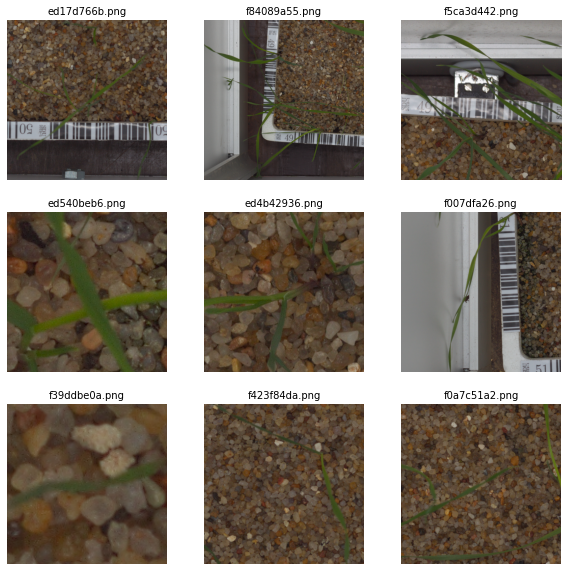

In [8]:
fig = plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.title(str(images_train[i]).split('/')[-1], fontsize=10) #get the file name and disply as title
    plt.imshow(PIL.Image.open(images_train[i]))
    ax = plt.axis("off")

In [9]:
batch_size = 32
img_height = 256
img_width = 256

###  Building Training Data Set from images

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.8, #80% training
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3921 files belonging to 12 classes.
Using 785 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2, #20% validation
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3921 files belonging to 12 classes.
Using 784 files for validation.


### Classification of data


In [12]:
from sklearn import preprocessing

In [ ]:
le = preprocessing.LabelEncoder()

In [13]:
class_names = train_ds.class_names
print('The name of the classes are: ')
for c in class_names:
    print('\t*',c)
    

The name of the classes are: 
	* Black-grass
	* Charlock
	* Cleavers
	* Common Chickweed
	* Common wheat
	* Fat Hen
	* Loose Silky-bent
	* Maize
	* Scentless Mayweed
	* Shepherds Purse
	* Small-flowered Cranesbill
	* Sugar beet


In [14]:
le.fit(class_names)

NameError: ignored

In [ ]:
le.classes_

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype='<U25')

In [ ]:
y_labelEncoded = le.transform(['Sugar beet'])

In [ ]:
le.transform(['Black-grass','Sugar beet'])

array([ 0, 11])

###  https://www.kaggle.com/subhasom/tensorflow-advance-plant-seedlings-classification

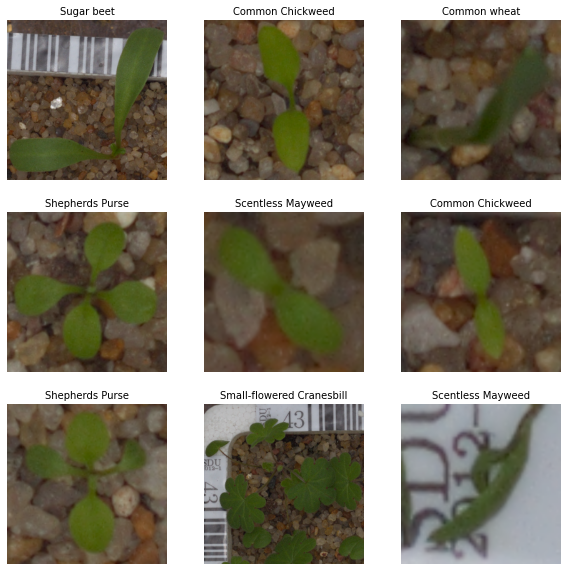

In [15]:
fig = plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.title(class_names[labels[i]], fontsize=10)
        plt.imshow(images[i].numpy().astype("uint8"))
        ax = plt.axis("off")

### building the model

### This step normalizes the data between 0 and 1

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) #lambda
#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), le.transform(y))) #lambda
image_batch, labels_batch = next(iter(normalized_ds))

first_image = image_batch[0]

print(np.min(first_image), np.max(first_image)) #pixels values are now in [0,1].

0.011118272 0.53998166


In [17]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

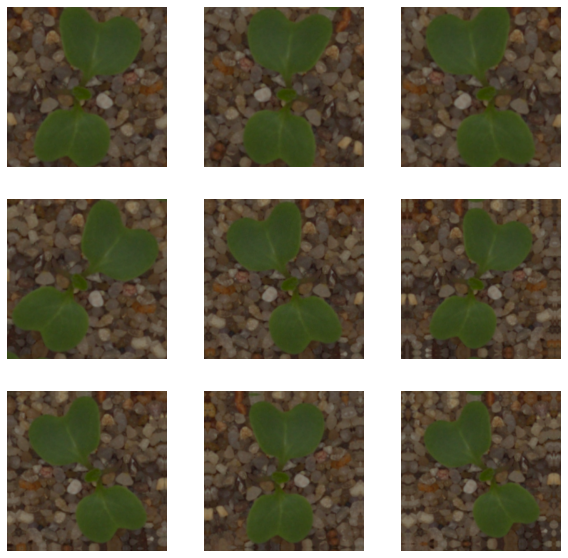

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        ax = plt.axis("off")

### Compiling the model

In [20]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(img_width,img_height,3,))) # Input layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')) # 2D Convolution layer
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) # Max Pool layer 
model.add(tf.keras.layers.BatchNormalization()) # Normalization layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu')) # 2D Convolution layer
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) # Max Pool layer 
model.add(tf.keras.layers.BatchNormalization()) # Normalization layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) # 2D Convolution layer
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) # Max Pool layer 
model.add(tf.keras.layers.BatchNormalization()) # Normalization layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu')) # 2D Convolution layer
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2))) # Max Pool layer 
model.add(tf.keras.layers.GlobalMaxPool2D()) # Global Max Pool layer
model.add(tf.keras.layers.Flatten()) # Dense Layers after flattening the data
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2)) # Dropout
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization()) # Normalization layer
model.add(tf.keras.layers.Dense(12, activation='softmax')) # Add Output Layer

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 127, 127, 64)      256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 128)      

### Training

In [23]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath="/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/CNN_Models_Aug2_c/", 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True)

In [ ]:
epochs = 50 #15 #the cycle
activity = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=checkpoint)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


17/25 [===================>..........] - ETA: 1s - loss: 2.8418 - accuracy: 0.1210

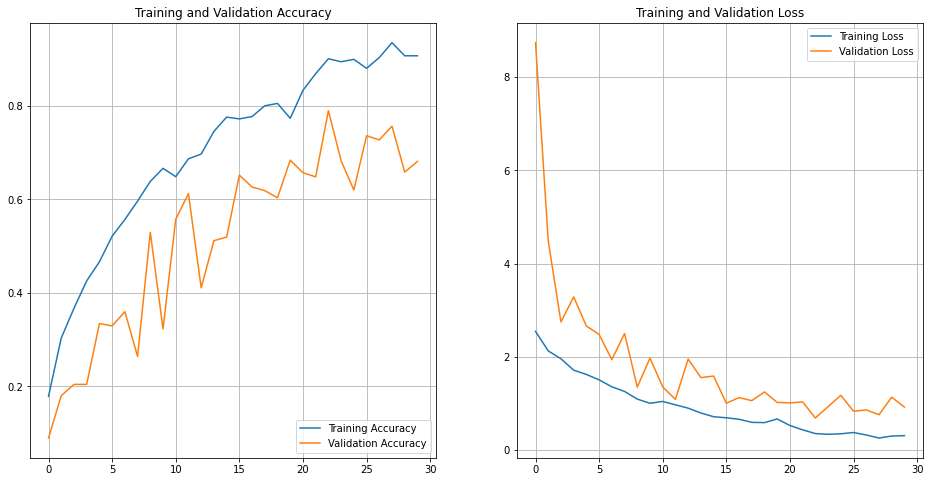

In [ ]:
acc = activity.history['accuracy']
val_acc = activity.history['val_accuracy']

loss = activity.history['loss']
val_loss = activity.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()

plt.show()

In [ ]:
data_dir_test_path = '/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/test/1b490196c.png'

img = keras.preprocessing.image.load_img(data_dir_test_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) #in the format it should be to perform prediction

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

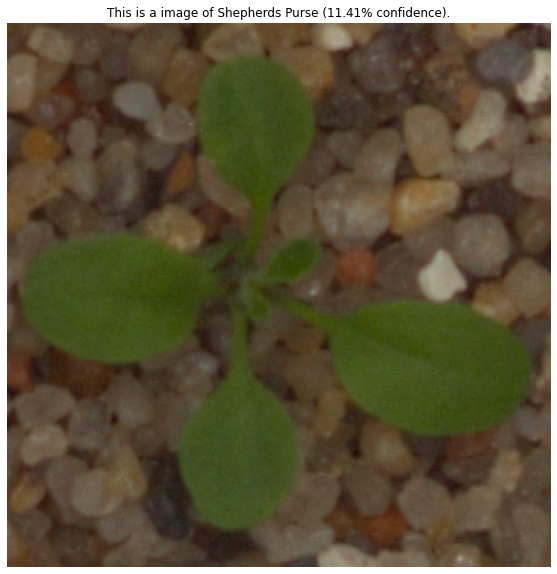

In [ ]:
plt.figure(figsize=(10, 10))
plt.title("This is a image of {} ({:.2f}% confidence).".format(class_names[np.argmax(score)], 100 * np.max(score)), fontsize=12)
plt.imshow(PIL.Image.open(data_dir_test_path))
ax = plt.axis("off")

In [ ]:
model.save("/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/CNN_Models_Aug2_c/CNN_seedling_v5.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
model.save_weights("/content/drive/My Drive/ModelMonitoringBlog/Rupas_Files_WIP/Rupa_Data/CNN_Models_Aug2_b/weights_CNN_seedling_v5")